ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **05Mar21**

# 07. Poisson 1D with Dirichlet-Neumann Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Constant Normal Flux Boundary Condition Case (Neumann)](#nbc)
 + [Strong Form of Problem Statement](#nbcstrong)
 + [Variational Form of Problem Statement](#nbcweak)
 + [Dirichlet-Neumann Energy](#nbcenergy)
  + [Problem Setup](#nbcsetup)
   - [Normal Flux Boundary Condition Term Kernel](#nfluxbc)
   - ["Draining" Boundary Condition (input file)](#nbcinput1)
   - [Run App](#nbcrun1)
   - [Quadratic Lagrange FEM Results](#nbcquadfemresults1)
   - ["Feeding" Boundary Condition (input file)](#nbcinput2)
   - [Run App](#nbcrun2)
   - [Quadratic Lagrange FEM Results](#nbcquadfemresults2)

## [Objectives](#toc)<a id="obj"></a>

 + Begin using [`MOOSE`](https://mooseframework.inl.gov) to practice solving ODE's. Therefore access to a working [`MOOSE`](https://mooseframework.inl.gov) installation is necessary. Additional local information on installation for your computer setting can be found [here](https://github.com/UML-Linux-Club/moose-info).
 + Introduce the Galerkin variational (weak) form of the Poisson 1D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
 + Introduce the use of Dirichlet and Neumann boundary conditions.
 + Use second order accurate finite element Lagrange basis functions to solve the problem numerically.
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. If you do not do a minimum of programing you will not learn basic aspects of this subject. Hands-on work during lectures will fill in this gap. If you do all the steps proposed in this notebook and attend the working lectures you will only have an initial knowledge of the subject.</span>

## [Constant Normal Flux Boundary Condition Case (Neumann)](#toc)<a id="nbc"></a>

The diffusion flux associated to $u$ is defined as

\begin{equation*}
 q(x) := -D\,u'(x).
\end{equation*}

The normal diffusion flux evaluated at boundary points is defined in 1D as:

\begin{align*}
 q_n(a) &:= - q(a),  \\
 q_n(b) &:= q(b).
\end{align*}

Therefore a positive value of normal flux $q_n$ at any boundary point indicates that the quantity $u$ is removed at the boundary. Otherwise, when $q_n$ is negative, $u$ is greater at the boundary as compared to the interior. The *normal* qualification here refers to the direction of the outward pointing vector at the boundary. Since this is a 1D problem, at the exit $b$, the normal aligns with the coordinate $x$ direction. At $a$ the normal is pointing in the opposite direction of the coordinate system; therefore the minus sign in the above definition.

In the literature, the **Neumann boundary condition** is given on the *normal derivative* (or normal gradient) of the unknown variable. This is not the same as the normal diffusion flux but related.

Here we will employ a mix of Dirichlet boundary condition on the entry point and a normal flux boundary condition on the exit point. That is:

\begin{align*}
 u(a) &= A, \\
 -D\,u'(b) &= q_b = q_n(b),
\end{align*}

where $q_b$ is the value to be specified. If this value is positive, $u$  will be depleted at the boundary.

### [Strong Form of Problem Statement](#toc)<a id="nbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\in\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 q_n(b) &= q_b.
\end{align*}
   
Solve this problem analytically for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, and exit flux, $q_b$. 

### [Variational Form of Problem Statement](#toc)<a id="nbcweak"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx - q_n(b)\,v(b) + \int\limits_a^b S\,v(x)\,dx  &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\in\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1\!\bigl([a,b]\bigr), v(a) = 0 \bigr\}$. This variational form is a modified Galerkin's weak form including the Neumann boundary condition.

### [Dirichlet-Neumann Energy](#toc)<a id="nbcenergy"></a>

The associated energy that the variational form minimizes is the **mixed Dirichlet/Neumann total energy**:

\begin{align*}
 \Phi[u] := \int\limits_a^b \,\frac{1}{2}q^2 - D\,S\,u(x) \,dx + D\,q_n(b)\,u(b).
\end{align*}

### [Problem Setup](#toc)<a id="nbcsetup"></a>

The previously developed code for the Dirichlet boundary condition case remains unchanged and usable.
To setup the new term in the weak form, there exists two options. First, implement a new MOOSE kernel to be added to the weak form terms. This is the approach followed here and there is a template in the course repository, `EquationFluxBC` which can be used as a starting point. In the Input file blocks shown below, the `type = NormalFluxBC` was created in the `Engy5310P1App` for this example. This approach implements an extended version of the normal diffusion flux [(see also Notebook 08)](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/08-poisson-1d-robin.ipynb).

The second approach, is to use the internal `MOOSE` framework implementation of the `NeumannBC` type in the boundary condition block of the input file. Start with the easier approach by just modifying your `MOOSE` boundary condition block as follows.

#### [Use Neumann Boundary Condition from MOOSE](#toc)<a id="nfluxbc"></a>

```
[BCs]
  [entry]
    type = DirichletBC  # part of MOOSE
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [exit]
    type = NeumannBC  # part of MOOSE
    variable = u
    boundary = right
    value = 4.10000e-01   # part of MOOSE
  []
[]

```

#### [Code a Normal Flux Boundary Condition Kernel](#toc)<a id="nfluxbc"></a>

To make this useful for the [Robin boundary condition case](#rbc) later, implement a linear transfer function as [follows](#rbcsetup):

\begin{equation*}
 q_n(x) =  q_\text{bias} + h\,\bigl(u(x) - u_\infty\bigr).
\end{equation*}

but set $h$ to zero at the moment.

1. `cd include`
1. `mkdir bcs`
1. `cd bcs`
1. Create a `NormalFluxBC.h` class interface as folows:
 + Use the `EquationFluxBC.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationFluxBC.h) as follows:
 + `cp *path-to*/moose-app-templates/EquationFluxBC.h .`
 + `mv EquationFluxBC.h NormalFluxBC.h`
 + Edit the file `NormalFluxBC.h` with a text editor by replacing all instances of `EquationFluxBC` with `NormalFluxBC`.
 + Suggestion: you will need to declare member variables named `_bias`, `_transferCoeff`, `_reference`, as `Real` data type.
1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `NormalFluxBC.C` class implementation as follows:
 + Use the `EquationFluxBC.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationFluxBC.C) as follows.
 + `cp *path-to*/moose-app-templates/EquationFluxBC.C .`
 + `mv EquationFluxBC.C NormalFluxBC.C`
 + Edit the file `EquationFluxBC.C` with a text editor by replacing all instances of `EquationFluxBC` with `NormalFluxBC`.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is covered in class.</span>

#### ["Draining" Boundary Condition (input file)](#toc)<a id="nbcinput1"></a>

The *draining* boundary condition uses a positive normal diffusion flux at the exit point, therefore there exists diffusion *removal* of material at that point.

Using the previous `input.i` input file (edit with a text editor), the `exit` block was modified as follows:

```
[BCs]
  [entry]
    type = DirichletBC  # part of MOOSE
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [exit]
    type = NormalFluxBC  # user built
    variable = u
    boundary = right
    bias = 4.10000e-01   # user built
  []
[]

```


Save the input file in the `.../engy5310p1/` directory.

#### [Run Application](#toc)<a id="nbcrun1"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

#### [Quadratic Lagrange FEM](#toc)<a id="nbcquadfemresults1"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = 0.41 g/cm^2-s  (the bias parameter)
> + D = 0.1 cm^2/s
> + S = 5e-2 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [13]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3

diff_coeff = 0.1
source_s = 5e-2

qn_b = 0.41 # draining on the exit boundary; normal diffusion flux is positive

n_felem = 1
order = 'second'
n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, qn_bias=qn_b, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts, use_moose_neumann_bc=True)

In [14]:
'''Display MOOSE input file created'''

!cat engy5310p1/new_input.i

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Mar21 14:10:21

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
qn_bias = 4.10000e-01

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
[]

[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxComponent
    field = u
    diffCoeff = ${replace diff_coeff}
    component = x
    vari

In [15]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/new_input.i



Framework Information:
MOOSE Version:           git commit 6fac045ef1 on 2021-02-25
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.13.5
SLEPc Version:           3.13.3
Current Time:            Fri Mar  5 14:10:21 2021
Executable Timestamp:    Fri Mar  5 13:49:39 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 3
    Local:                 3
  Elems:                   
    Total:                 1
    Local:                 1
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                2
  Num Local DOFs:          2
  Variables:    

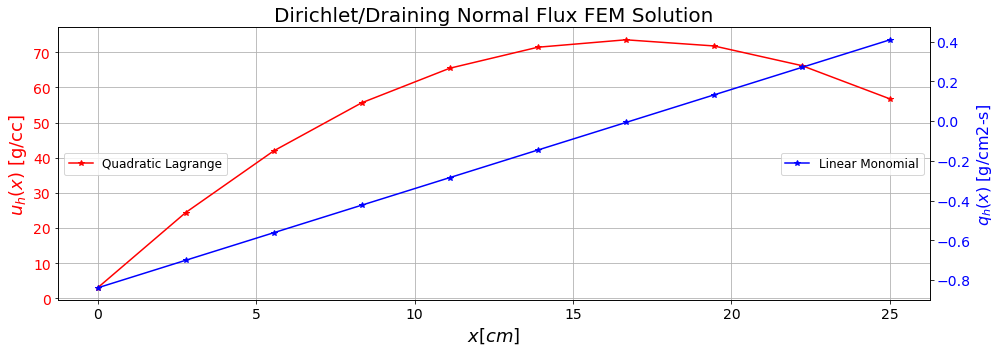

In [16]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet/Draining Normal Flux FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

1. Because the flux at the exit is specified as positive, there is outgoing diffusion at the exit point of the domain, hence despite the constant source, the exit concentration is reduced to levels near the entry concentration. If the specified flux is too high compared to the source (or the source small compared to the flux) it will drive the concentration values at the exit to unphysical negative values.
1. Note that 1 finite element was used.

#### ["Feeding" Boundary Condition (input file)](#toc)<a id="nbcinput2"></a>

The *feeding* boundary condition uses a negative normal diffusion flux at the exit point, therefore there exists diffusion *feed* of material at that point.

In a similar way to the *draining* flux previously described the input file was modified as follows:

```
[exit]
  type = NormalFluxBC
  variable = u
  boundary = right
  bias = -0.5
[]
```


Save the input file in the `.../engy5310p1/` directory.

#### [Run Application](#toc)<a id="nbcrun2"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

#### [Quadratic Lagrange FEM](#toc)<a id="nbcquadfemresults2"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = -0.5 g/cm^2-s
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [17]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3

diff_coeff = 0.1
source_s = 5e-2

qn_b = -0.5 # feeding on the exit boundary; normal flux is negative

n_felem = 1
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import write_engy5310_p1_input_file

write_engy5310_p1_input_file(x_a, x_b, u_a=u_a, qn_bias=qn_b, 
                             diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                             n_plot_pts=n_plot_pts, use_moose_neumann_bc=True)

In [18]:
'''Display MOOSE input file created'''

!cat engy5310p1/new_input.i

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Mar21 14:10:21

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
qn_bias = -5.00000e-01

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
[]

[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxComponent
    field = u
    diffCoeff = ${replace diff_coeff}
    component = x
    var

In [19]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/new_input.i



Framework Information:
MOOSE Version:           git commit 6fac045ef1 on 2021-02-25
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.13.5
SLEPc Version:           3.13.3
Current Time:            Fri Mar  5 14:10:21 2021
Executable Timestamp:    Fri Mar  5 13:49:39 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 3
    Local:                 3
  Elems:                   
    Total:                 1
    Local:                 1
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                2
  Num Local DOFs:          2
  Variables:    

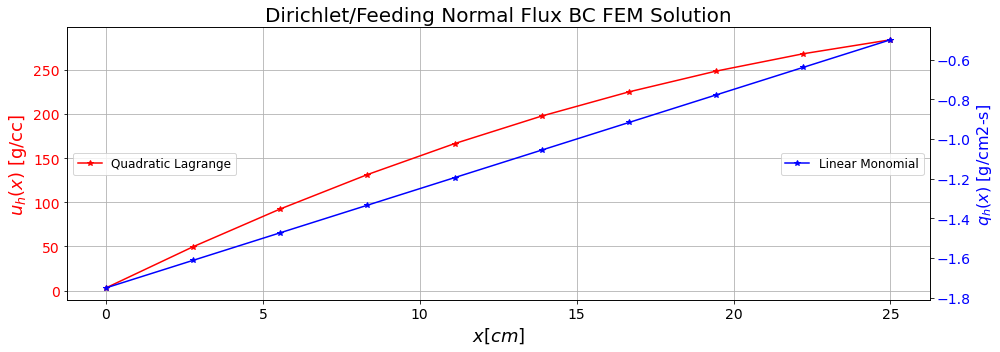

In [20]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet/Feeding Normal Flux BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

1. Because the normal flux at the exit is specified as negative, there is incoming diffusion into the domain, hence the concentration is higher at the exit than the entry point. The average concentration in the domain is greatly increased at steady state.
1. Note that 1 finite element was used.